In [1]:
! pip install --upgrade pytorch-lightning einops astropy nflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 90.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 741.1/741.1 kB 109.5 MB/s eta 0:00:00
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53654 sha256=721baa5e975b59cdf7e2332fc4fb3b46fa3c225108942cdcc9ac58b3024b8dab
  Stored in directory: /root/.cache/pip/wheels/e1/08/10/19b7420ee82c99f10c57f6b50c982f7416722490133cc85bc3
Successfully built nflows


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

torch.set_float32_matmul_precision("medium")

from einops import rearrange, repeat
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from tqdm import tqdm
from collections import defaultdict

import sys
sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from jax.config import config
config.update("jax_enable_x64", True)

In [4]:
from simulators.lensing import LensingSim

## Simulation

In [5]:
def _mag_to_flux(mag, mag_zp):
    """
    Returns total flux of the integrated profile corresponding to magnitude `mag`, in ADU relative to `mag_zp`
    """
    return 10 ** (-0.4 * (mag - mag_zp))

In [6]:
import jax.scipy as jsp

# Lensing image configuration

exposure = 1610.0
n_xy = 64
pixel_size = 0.1 * n_xy / n_xy
mag_zero = 25.5
mag_iso = 22.5
mag_s = 23.0
fwhm_psf = 0.18

coordinate_limit = pixel_size * n_xy / 2.0
f_iso = _mag_to_flux(mag_iso, mag_zero)

observation_dict = {"n_x": n_xy, "n_y": n_xy, "theta_x_lims": (-coordinate_limit, coordinate_limit), "theta_y_lims": (-coordinate_limit, coordinate_limit), "exposure": exposure, "f_iso": f_iso,}

theta_x_0 = 0.
theta_y_0 = 0.
theta_s_e = 0.4

S_tot = _mag_to_flux(mag_s, mag_zero)

global_dict = {"z_s": 1., "z_l": 0.2}
hst_param_dict = {"profile": "SIE", "theta_x_0": 0.12, "theta_y_0": -0.2, "theta_E": 2.15, "q": 0.8}
src_param_dict = {"profile": "Sersic", "theta_x_0": theta_x_0, "theta_y_0": theta_y_0, "S_tot": S_tot, "theta_e": theta_s_e, "n_srsc": 1}

In [7]:
from simulators.units import *
from simulators.lensing_profiles import MassProfileNFW

In [8]:
def _draw_m_sub(n_sub, m_sub_min, m_sub_max, beta):
    """
    Draw subhalo masses from SHMF with slope `beta` and min/max masses `m_sub_min` and `m_sub_max` . Stolen from:
    https://stackoverflow.com/questions/31114330/python-generating-random-numbers-from-a-power-law-distribution
    """
    u = np.random.uniform(0, 1, size=n_sub)
    m_low_u, m_high_u = m_sub_min ** (beta + 1), m_sub_max ** (beta + 1)
    return (m_low_u + (m_high_u - m_low_u) * u) ** (1.0 / (beta + 1.0))

def _draw_sub_coordinates(n_sub, r_min=0.0, r_max=2.5):
    """
    Draw subhalo n_sub coordinates uniformly within a ring r_min < r < r_max
    """
    x_sub = []
    y_sub = []
    while len(x_sub) < n_sub:
        x_candidates = np.random.uniform(low=-r_max, high=r_max, size=n_sub - len(x_sub))
        y_candidates = np.random.uniform(low=-r_max, high=r_max, size=n_sub - len(x_sub))
        r2 = x_candidates ** 2 + y_candidates ** 2
        good = (r2 <= r_max ** 2) * (r2 >= r_min ** 2)
        x_sub += list(x_candidates[good])
        y_sub += list(y_candidates[good])

    return jnp.array(x_sub), jnp.array(y_sub)

In [9]:
from jax import jit

@jit 
def simulate(sample, key=jax.random.PRNGKey(136)):
    
    src_param_dict = {"profile": "Sersic", "theta_x_0": 0., "theta_y_0": 0., "S_tot": S_tot, "theta_e": 0.4, "n_srsc": 1}
    hst_param_dict = {"profile": "SIE", "theta_x_0": sample['theta_x'], "theta_y_0": sample['theta_y'], "theta_E": sample['theta_E'], "q": sample['q']}
            
    lens_list = [hst_param_dict]
    
    z_x, z_c, z_c_tot = sample['z_x'], sample['z_c'], sample['z_c_tot']
    
    subs_list = []
    for z_i in jnp.arange(n_ps_sim_max):
                        
        m = 10 ** z_c[z_i].astype(float) * M_s
        c = MassProfileNFW.c_200_SCP(m)
        r_s, rho_s = MassProfileNFW.get_r_s_rho_s_NFW(m, c)
                    
        sub_param_dict = {"profile": "NFW", "theta_x_0": z_x[z_i, 0], "theta_y_0": z_x[z_i, 1], "M_200": m, "r_s": r_s, "rho_s": rho_s}
        
        subs_list.append(sub_param_dict)
        
    lsi = LensingSim(lens_list, subs_list, [src_param_dict], global_dict, observation_dict)
    image_smoothed = lsi.lensed_image()
    
    key, subkey = jax.random.split(key)
    image = jax.random.poisson(key, image_smoothed)

    return {'beta': sample['beta'], 'Sigma_sub': sample['Sigma_sub'], 'z_c_tot': z_c_tot, "theta_x": sample['theta_x'], "theta_y": sample['theta_y'], "theta_E": sample['theta_E'], "q": sample['q'], 'x': image.T}

In [13]:
n_set_max = 25
n_sim = 5000
n_ps_sim_max = 200

subs_trees = []
sample_trees = []

n_sample_list = []

for i in tqdm(range(n_sim)):
    
    # Draw "global" parameters
    beta = np.random.uniform(-2.5, -1.9)
    Sigma_sub = np.random.uniform(0., 20.)
    
    n_sample = n_set_max
    n_sample_list.append(n_sample)
    
    # Draw "local" parameters
    for i_sample in range(n_sample):
        
        sample_local = {'theta_x': np.random.normal(0., 0.2) , 'theta_y': np.random.normal(0., 0.2), 'theta_E': np.random.uniform(1.5, 2.5), 'q': np.random.uniform(0.5, 0.99)}
        sample_trees.append(sample_local)
        
        r_max = sample_local['theta_E'] + 0.2
        r_min = sample_local['theta_E'] - 0.2
        
        mu_sub = np.pi * (r_max ** 2 - r_min ** 2) * Sigma_sub
        n_sub = np.random.poisson(mu_sub)
        
        z_x_all = np.zeros((2, n_ps_sim_max))
        z_c_all = np.zeros(n_ps_sim_max)
                
        z_c_all[:n_sub] = _draw_m_sub(n_sub, 8., 12., beta)
        z_x_all[:, :n_sub] = np.array(_draw_sub_coordinates(n_sub, r_min=r_min, r_max=r_max))

        z_c_tot = (10 ** z_c_all).sum() / 1e12

        subs_trees.append({'beta':beta, 'Sigma_sub':Sigma_sub, 'z_x':jnp.array(z_x_all).T, 'z_c':jnp.array(z_c_all), 'z_c_tot':z_c_tot})
        
n_sim_tot = np.sum(n_sample_list)

[sample_tree.update(subs_tree) for sample_tree, subs_tree in zip(sample_trees, subs_trees)];

simulations = [simulate(sample) for sample in tqdm(sample_trees)]

simulations_dict = defaultdict(list)

for d in simulations:
    for key, value in d.items():
        simulations_dict[key].append(value)

for key, value in d.items():
    simulations_dict[key] = np.array(simulations_dict[key])


100%|██████████| 125000/125000 [38:30<00:00, 54.09it/s] 


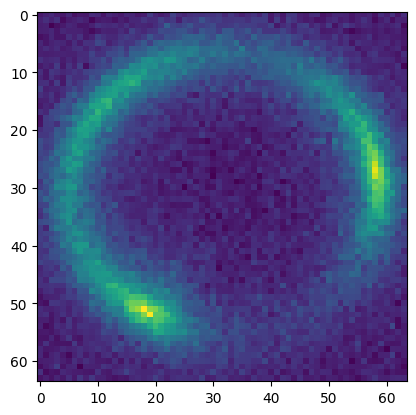

In [14]:
i_tr = np.random.randint(5)
plt.imshow(simulations_dict['x'][i_tr])

## Data and data loaders

In [12]:
y_local = torch.Tensor([simulations_dict['theta_x'], simulations_dict['theta_y'], simulations_dict['theta_E'], simulations_dict['q']]).T
y_local = rearrange(y_local, "(batch n_set) n_param -> batch n_set n_param", n_set=n_set_max)

y_global = torch.Tensor([simulations_dict['beta'], simulations_dict['Sigma_sub']]).T
y_global = rearrange(y_global, "(batch n_set) n_param -> batch n_set n_param", n_set=n_set_max)[:, 0, :]

x = torch.Tensor(simulations_dict['x'][:])
y_local = torch.Tensor(y_local[:])
y_global = torch.Tensor(y_global[:])
x = rearrange(x, "(batch n_set) h w -> batch n_set h w", n_set=n_set_max)

In [17]:
np.savez("./x_global_local_train.npz",
         x=x,
         y_local=y_local,
         y_global=y_global,
         x_mean=x.mean(),
         y_local_mean=y_local.mean([0, 1]),
         y_global_mean=y_global.mean([0]),
         x_std=x.std(),
         y_local_std=y_local.std([0, 1]),
         y_global_std=y_global.std([0]),
         n_set_max=n_set_max
        )

## Model: Gloabl variable inference network

In [27]:
from models.resnet import ResNetEstimator
from models.flows import build_mlp, build_maf

In [28]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping

In [46]:
class HierarchicalDeepSet(nn.Module):
    """ Backbone to the hierarchical deep set model, using a ResNet embedder and MAF flows for 
        local and global parameter posterior density estimators.
    """
    def __init__(self, dim_hidden=128, condition_local_on_global=True):
        super(HierarchicalDeepSet, self).__init__()
        
        inference_net_kwargs = {"cfg":50}
        self.enc = ResNetEstimator(n_out=dim_hidden, **inference_net_kwargs)
        self.dec = build_mlp(input_dim=int(dim_hidden / 2) + 1, hidden_dim=int(2 * dim_hidden), output_dim=int(dim_hidden / 2), layers=4)
        
        # Condition local flow on global params if local loss is turned on
        extra_context = 2 if condition_local_on_global else 0
        self.condition_local_on_global = condition_local_on_global
        
        self.flow_local = build_maf(dim=4, num_transforms=6, context_features=int(dim_hidden / 2) + extra_context, hidden_features=int(2 * dim_hidden))
        self.flow_global =  build_maf(dim=2, num_transforms=6, context_features=int(dim_hidden / 2), hidden_features=int(2 * dim_hidden))

    def forward(self, x, y_local, y_global):
        
        n_batch = x.shape[0]

        lens = torch.randint(low=1, high=n_set_max + 1,size=(n_batch,), dtype=torch.float)
        mask = (torch.arange(n_set_max).expand(len(lens), n_set_max) < torch.Tensor(lens)[:,None]).to(x.device)
        
        x = rearrange(x, "batch n_set h w -> (batch n_set)  h w", n_set=n_set_max)
        x = self.enc(x)
        
        x = rearrange(x, "(batch n_set) n_out -> batch n_set n_out", n_set=n_set_max) 
        
        idx_setperm = torch.randperm(n_set_max)  # Permutation indices
        x = x[:, idx_setperm, :] * mask[:, :, None]  # Permute set elements and mask
        y_local = y_local[:, idx_setperm, :]
                                
        x, x_cond_local = torch.chunk(x, 2, -1)
        
        x = x.sum(-2) / mask.sum(1)[:, None]
                
        x = torch.cat([x, lens[:, None].to(x.device)], -1)  # Add cardinality for rho network
        x_cond_global = self.dec(x)
                        
        x_cond_local = rearrange(x_cond_local, "batch n_set n_out -> (batch n_set) n_out", n_set=n_set_max)
            
        if self.condition_local_on_global:
            y_global_repeat = repeat(y_global, "batch glob -> (batch n_set) glob", n_set=n_set_max)
            x_cond_local = torch.cat([x_cond_local, y_global_repeat], -1)
        
        y_local = rearrange(y_local, "batch n_set n_param -> (batch n_set) n_param", n_set=n_set_max)
                
        log_prob_local = self.flow_local.log_prob(y_local, x_cond_local)
        log_prob_local = rearrange(log_prob_local, "(batch n_set) -> batch n_set", n_set=n_set_max)
        log_prob_local = (log_prob_local * mask).sum(-1)

        log_prob_global = self.flow_global.log_prob(y_global, x_cond_global)
        
        return log_prob_local, log_prob_global

In [47]:
class HierarchicalDeepSetInference(pl.LightningModule):
    """ Hierarchical deep set lightning module for training and inference.
    """

    def __init__(self, optimizer=torch.optim.AdamW, 
                         optimizer_kwargs={"weight_decay":5e-5}, 
                         lr=3e-4, 
                         max_epochs=50,
                         scheduler=torch.optim.lr_scheduler.CosineAnnealingLR,
                         local_loss=True,
                         global_loss=True,  # Whether to use 
                         ):
        super().__init__()
        
        self.optimizer = optimizer
        self.optimizer_kwargs = optimizer_kwargs
        self.scheduler = scheduler
        self.scheduler_kwargs = {"T_max":max_epochs}
        self.lr = lr
        
        self.local_loss = local_loss
        self.global_loss = global_loss
        
        # Condition local flow on global params only if both are turned on
        condition_local_on_global = True if (local_loss and global_loss) else False
                
        self.deep_set = HierarchicalDeepSet(condition_local_on_global=condition_local_on_global)
        
    def forward(self, x, y_local, y_global):
        log_prob = self.deep_set(x, y_local, y_global)
        return log_prob
        
    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), lr=self.lr, **self.optimizer_kwargs)
        
        return {"optimizer": optimizer, 
                    "lr_scheduler": {
                    "scheduler": self.scheduler(optimizer, **self.scheduler_kwargs),
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 1}
                }
            
    def training_step(self, batch, batch_idx):
        x, y_local, y_global = batch
        log_prob_local, log_prob_global = self(x, y_local, y_global)    
        log_prob = torch.zeros_like(log_prob_local).to(log_prob_local.device)
        if self.local_loss:
            log_prob += log_prob_local
        if self.global_loss:
            log_prob += log_prob_global   
        loss = -log_prob.mean()
        self.log('train_loss', loss, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y_local, y_global = batch
        log_prob_local, log_prob_global = self(x, y_local, y_global)     
        log_prob = torch.zeros_like(log_prob_local).to(log_prob_local.device)
        if self.local_loss:
            log_prob += log_prob_local
        if self.global_loss:
            log_prob += log_prob_global   
        loss = -log_prob.mean()
        self.log('val_loss', loss, on_epoch=True)
        return loss

In [48]:
sample = np.load("./x_global_local_train.npz")
x, y_local, y_global = torch.Tensor(sample['x'])[:], torch.Tensor(sample['y_local'])[:], torch.Tensor(sample['y_global'])[:]

In [49]:
x_mean = x.mean()
y_local_mean = y_local.mean([0, 1])
y_global_mean = y_global.mean([0])

x_std = x.std()
y_local_std = y_local.std([0, 1])
y_global_std = y_global.std([0])

In [50]:
x = (x - x_mean) / x_std
y_local = (y_local - y_local_mean) / y_local_std
y_global = (y_global - y_global_mean) / y_global_std

In [51]:
batch_size = 16

val_fraction = 0.1
n_samples_val = int(val_fraction * len(x))

dataset = TensorDataset(x, y_local, y_global)

dataset_train, dataset_val = random_split(dataset, [len(x) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=False)

In [52]:
max_epochs = 50
model = HierarchicalDeepSetInference(max_epochs=max_epochs)
n_set_max = int(sample['n_set_max'])

In [53]:
# Lightning callbacks
checkpoint_callback = ModelCheckpoint(dirpath='global-model', monitor="val_loss", filename="global-{epoch:02d}-{val_loss:.2f}", every_n_epochs=4, save_top_k=1)
early_stop_callback = EarlyStopping(monitor='val_loss', patience=8)        
lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Instantiate trainer
trainer = pl.Trainer(max_epochs=max_epochs, accelerator="gpu", devices=1, gradient_clip_val=0.5, callbacks=[lr_monitor, checkpoint_callback, early_stop_callback])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /notebooks/set-inference/notebooks/global-model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                | Params
-------------------------------------------------
0 | deep_set | HierarchicalDeepSet | 30.1 M
-------------------------------------------------
30.1 M    Trainable params
0         Non-trainable params
30.1 M    Total params
120.278   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Test global variable inference

In [54]:
# model.load_from_checkpoint(checkpoint_callback.best_model_path, max_epochs=max_epochs);

model.deep_set.enc.to('cpu').eval()
model.deep_set.dec.to('cpu').eval()
model.deep_set.flow_local.to('cpu').eval()
model.deep_set.flow_global.to('cpu').eval();

In [74]:
n_set_max = 25
n_sim = 20
n_ps_sim_max = 200

subs_trees = []
sample_trees = []

n_sample_list = []

for i in tqdm(range(n_sim)):
    
    # Draw "global" parameters
    beta = np.random.uniform(-2.5, -1.9)
    Sigma_sub = np.random.uniform(0., 20.)
    
    n_sample = n_set_max
    n_sample_list.append(n_sample)
    
    # Draw "local" parameters
    for i_sample in range(n_sample):
        
        sample_local = {'theta_x': np.random.normal(0., 0.2) , 'theta_y': np.random.normal(0., 0.2), 'theta_E': np.random.uniform(1.5, 2.5), 'q': np.random.uniform(0.5, 0.99)}
        sample_trees.append(sample_local)
        
        r_max = sample_local['theta_E'] + 0.2
        r_min = sample_local['theta_E'] - 0.2
        
        mu_sub = np.pi * (r_max ** 2 - r_min ** 2) * Sigma_sub
        n_sub = np.random.poisson(mu_sub)

        z_x_all = np.zeros((2, n_ps_sim_max))
        z_c_all = np.zeros(n_ps_sim_max)
                
        z_c_all[:n_sub] = _draw_m_sub(n_sub, 8, 12., beta)
        z_x_all[:, :n_sub] = np.array(_draw_sub_coordinates(n_sub, r_min=r_min, r_max=r_max))

        z_c_tot = (10 ** z_c_all).sum() / 1e12

        subs_trees.append({'beta':beta, 'Sigma_sub':Sigma_sub, 'z_x':jnp.array(z_x_all).T, 'z_c':jnp.array(z_c_all), 'z_c_tot':z_c_tot})
        
n_sim_tot = np.sum(n_sample_list)

[sample_tree.update(subs_tree) for sample_tree, subs_tree in zip(sample_trees, subs_trees)];

simulations = [simulate(sample) for sample in tqdm(sample_trees)]

simulations_dict = defaultdict(list)

for d in simulations:
    for key, value in d.items():
        simulations_dict[key].append(value)

for key, value in d.items():
    simulations_dict[key] = np.array(simulations_dict[key])

100%|██████████| 500/500 [00:01<00:00, 334.17it/s]


In [75]:
y_local_test = torch.Tensor([simulations_dict['theta_x'], simulations_dict['theta_y'], simulations_dict['theta_E'], simulations_dict['q']]).T
y_local_test = rearrange(y_local_test, "(batch n_set) n_param -> batch n_set n_param", n_set=n_set_max)

y_global_test = torch.Tensor([simulations_dict['beta'], simulations_dict['Sigma_sub']]).T
y_global_test = rearrange(y_global_test, "(batch n_set) n_param -> batch n_set n_param", n_set=n_set_max)[:, 0, :]

x_test = torch.Tensor(simulations_dict['x'][:])
y_local_test = torch.Tensor(y_local_test[:])
y_global_test = torch.Tensor(y_global_test[:])
x_test = rearrange(x_test, "(batch n_set) h w -> batch n_set h w", n_set=n_set_max)

In [76]:
x_test = (x_test - x_mean) / x_std
y_local_test = (y_local_test - y_local_mean) / y_local_std
y_global_test = (y_global_test - y_global_mean) / y_global_std

## Grid

In [77]:
from matplotlib import cm
cmap = cm.get_cmap('viridis_r')

import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

import logging
import matplotlib

logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [78]:
import seaborn as sns
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

100%|██████████| 8/8 [00:19<00:00,  2.41s/it]


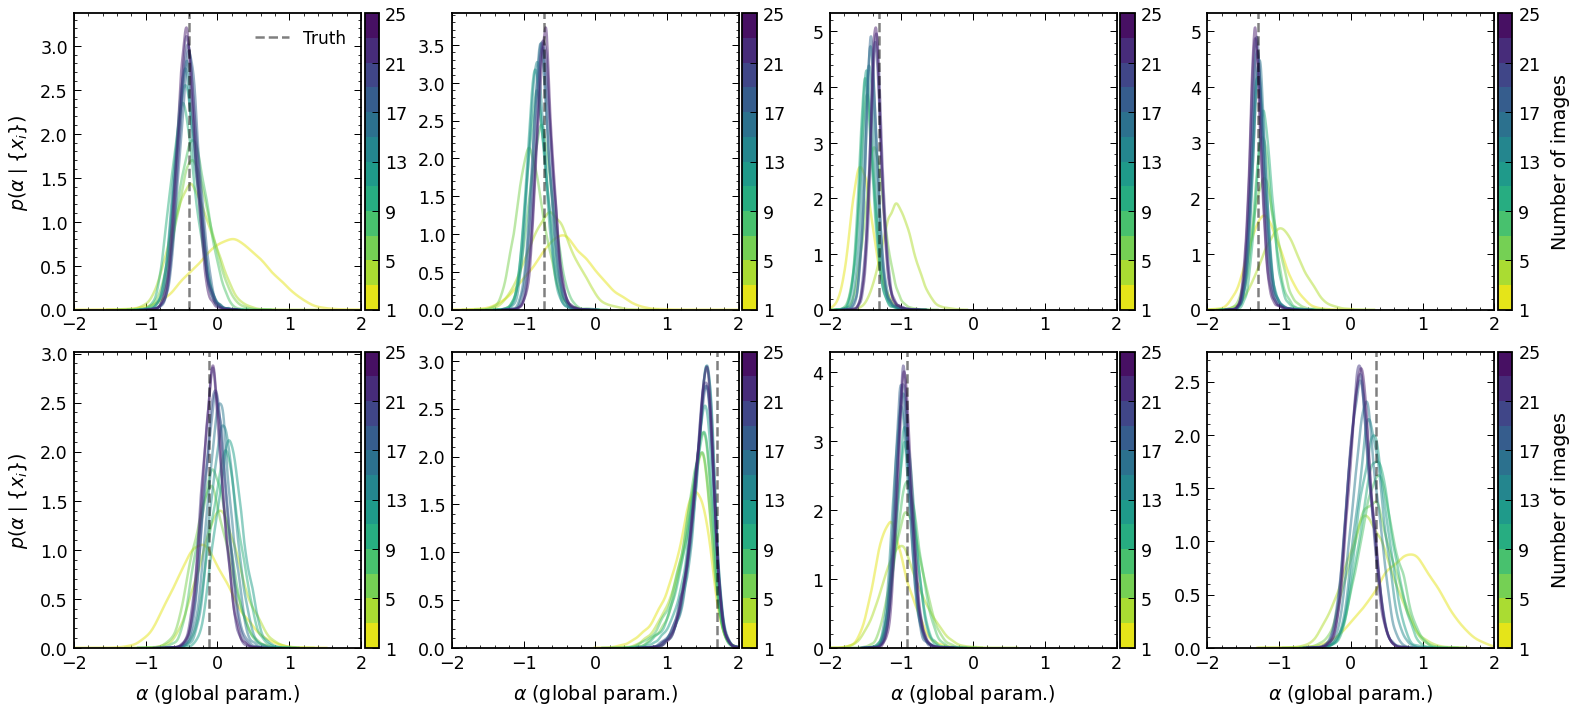

In [79]:
i_param = 1

n_ev_max = 25
n_skip = 2

fig = plt.figure(figsize=(22, 10))
gs = GridSpec(2, 4)

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(1, n_ev_max + 2, n_skip)

for i in tqdm(range(8)):
    
    ii = i # np.random.randint(20)
    
    ax = fig.add_subplot(gs[i])
    CS3 = ax.contourf(Z, levels, cmap=cmap)
    plt.cla()

    for n_ev in np.arange(1, n_ev_max, n_skip):

        x_enc = model.deep_set.enc.to('cuda')(x_test[ii, :n_ev].to('cuda'))
        x_enc, x_enc_cond_local = torch.chunk(x_enc, 2, -1)

        x_enc = x_enc.mean(-2)
        x_enc = torch.cat([x_enc.to('cpu'), torch.Tensor([n_ev])])
        samples = model.deep_set.flow_global.sample(num_samples=10000, context=model.deep_set.dec(x_enc.to('cpu')).unsqueeze(0))

        sns.kdeplot(data=samples[0, :, i_param].detach().numpy(), color=cmap(n_ev / n_ev_max), ax=ax, alpha=0.6)
        ax.set_ylabel(r"$p(\alpha\mid\{x_i\})$" if i in [0, 4] else None)

    ax.axvline(y_global_test[ii].detach().numpy()[i_param], label="Truth", ls='--', color='k')
    for line in ax.get_lines():
        line.set_alpha(0.5)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    
    fig.colorbar(CS3, cax=cax, orientation='vertical', label="Number of images" if i in [3,7] else None)
    
    if i in np.arange(4, 8):
        ax.set_xlabel(r"$\alpha$ (global param.)")

    ax.set_xlim(-2, 2)
    
    if i == 0:
        ax.legend()
    
plt.tight_layout()
# plt.savefig("../paper/figs/lensing_alpha.pdf")

## Local variable inference network

In [80]:
model_local = HierarchicalDeepSetInference(max_epochs=max_epochs, local_loss=True, global_loss=False)

In [81]:
# Lightning callbacks
checkpoint_callback = ModelCheckpoint(dirpath='local-model', monitor="val_loss", filename="local-{epoch:02d}-{val_loss:.2f}", every_n_epochs=4, save_top_k=1)
early_stop_callback = EarlyStopping(monitor='val_loss', patience=8)        
lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Instantiate trainer
trainer_local = pl.Trainer(max_epochs=max_epochs, accelerator="gpu", devices=1, gradient_clip_val=0.5, callbacks=[lr_monitor, checkpoint_callback, early_stop_callback])
trainer_local.fit(model=model_local, train_dataloaders=train_loader, val_dataloaders=val_loader)  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /notebooks/set-inference/notebooks/local-model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                | Params
-------------------------------------------------
0 | deep_set | HierarchicalDeepSet | 30.1 M
-------------------------------------------------
30.1 M    Trainable params
0         Non-trainable params
30.1 M    Total params
120.266   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [82]:
# model_local.load_from_checkpoint(checkpoint_callback.best_model_path, max_epochs=max_epochs);

model_local.deep_set.enc.to('cpu').eval()
model_local.deep_set.flow_local.to('cpu').eval();

100%|██████████| 6/6 [01:23<00:00, 13.94s/it]


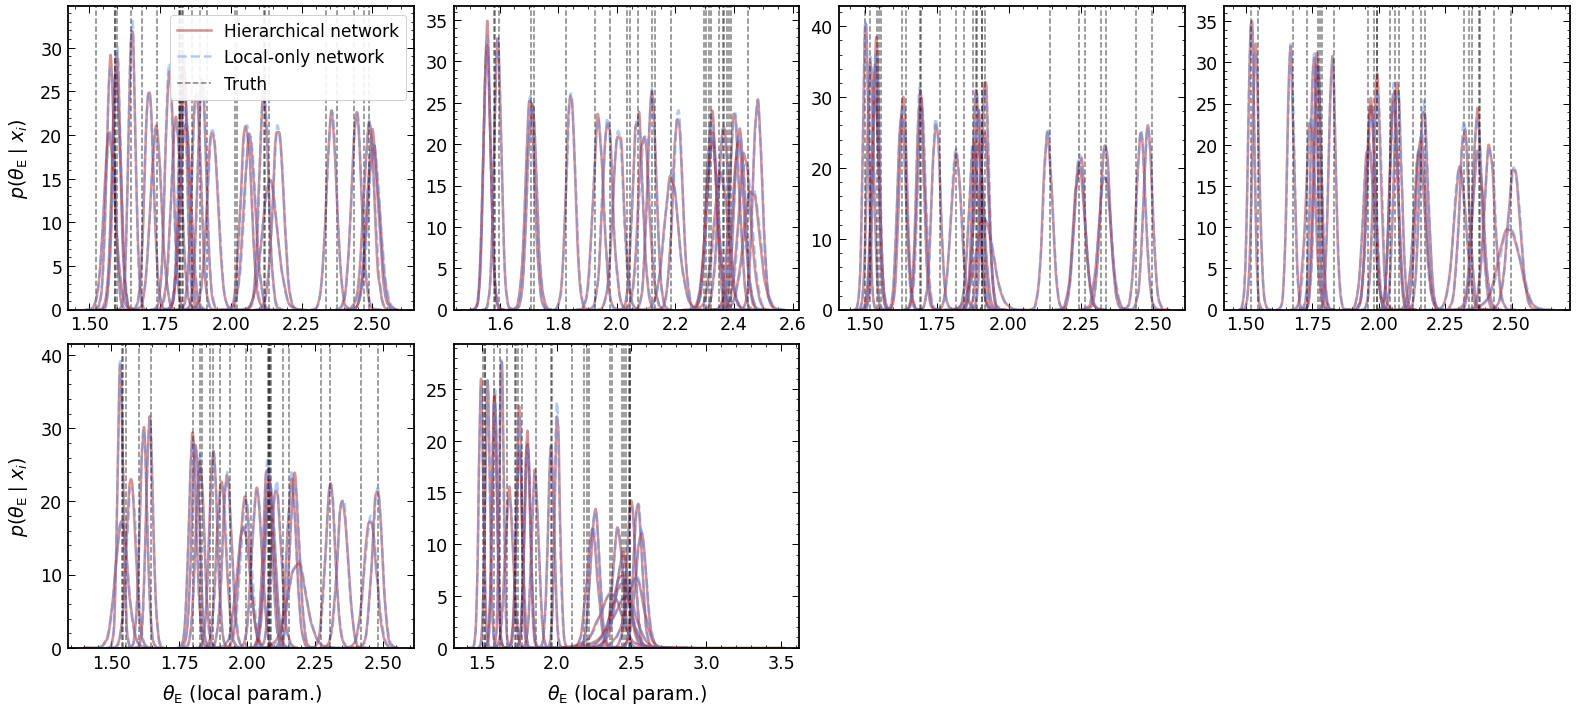

In [83]:
i_param = 2

n_ev_max = 25

fig = plt.figure(figsize=(22, 10))
gs = GridSpec(2, 4)

for i in tqdm(range(6)):
    
    ii = i
    
    ax = fig.add_subplot(gs[i])
    plt.cla()
    
    x_enc = model.deep_set.enc.to('cuda')(x_test[ii, :n_ev_max].to('cuda'))
    x_enc, x_enc_cond_local_global = torch.chunk(x_enc, 2, -1)
    x_enc = x_enc.mean(-2)
    x_enc = torch.cat([x_enc.to('cpu'), torch.Tensor([n_ev_max])])
    samples_global = model.deep_set.flow_global.sample(num_samples=32, context=model.deep_set.dec(x_enc.to('cpu')).unsqueeze(0))
    x_enc_cond_local_global = torch.cat([x_enc_cond_local_global.to('cpu'), repeat(samples_global.mean((0,1)), "glob -> n_ev_max glob", n_ev_max=n_ev_max)], -1)    
    samples_global_local = model.deep_set.flow_local.sample(num_samples=5000, context=x_enc_cond_local_global.to('cpu')) * y_local_std + y_local_mean
    
    for iii in range(n_ev_max):
        sns.kdeplot(data=samples_global_local[iii, :, i_param].detach().numpy(), color='firebrick', ax=ax, alpha=1., label="Hierarchical network" if iii==0 else None)
        
        x_enc = model.deep_set.enc.to('cuda')(x_test[ii, iii].unsqueeze(0).to('cuda'))
        x_enc, x_enc_cond_local_global = torch.chunk(x_enc, 2, -1)
        x_enc = x_enc.mean(-2)
        x_enc = torch.cat([x_enc.to('cpu'), torch.Tensor([1])])
        samples_global = model.deep_set.flow_global.sample(num_samples=32, context=model.deep_set.dec(x_enc.to('cpu')).unsqueeze(0))
        x_enc_cond_local_global = torch.cat([x_enc_cond_local_global.to('cpu'), repeat(samples_global.mean((0,1)), "glob -> n_ev_max glob", n_ev_max=1)], -1)
        
        samples_global_local_local = model.deep_set.flow_local.sample(num_samples=5000, context=x_enc_cond_local_global.to('cpu')) * y_local_std + y_local_mean
        
        sns.kdeplot(data=samples_global_local_local[0, :, i_param].detach().numpy(), color='cornflowerblue', ax=ax, alpha=1., ls='--', label="Local-only network" if iii==0 else None)
        
        ax.axvline((y_local_test * y_local_std + y_local_mean)[ii,iii].detach().numpy()[i_param], label="Truth" if iii==0 else None, ls='--', color='k', lw=1.5)

    ax.set_ylabel(r"$p(\theta_\mathrm{E}\mid x_i)$" if i in [0, 4] else None)

    for line in ax.get_lines():
        line.set_alpha(0.5)
    
    if i in np.arange(4, 8):
        ax.set_xlabel(r"$\theta_\mathrm{E}$ (local param.)")
    
    if i == 0:
        ax.legend(frameon=True, fancybox=True, framealpha=0.9, loc='upper right')
    
plt.tight_layout()
# plt.savefig("../paper/figs/lensing_local.pdf")

## Combined plot

100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


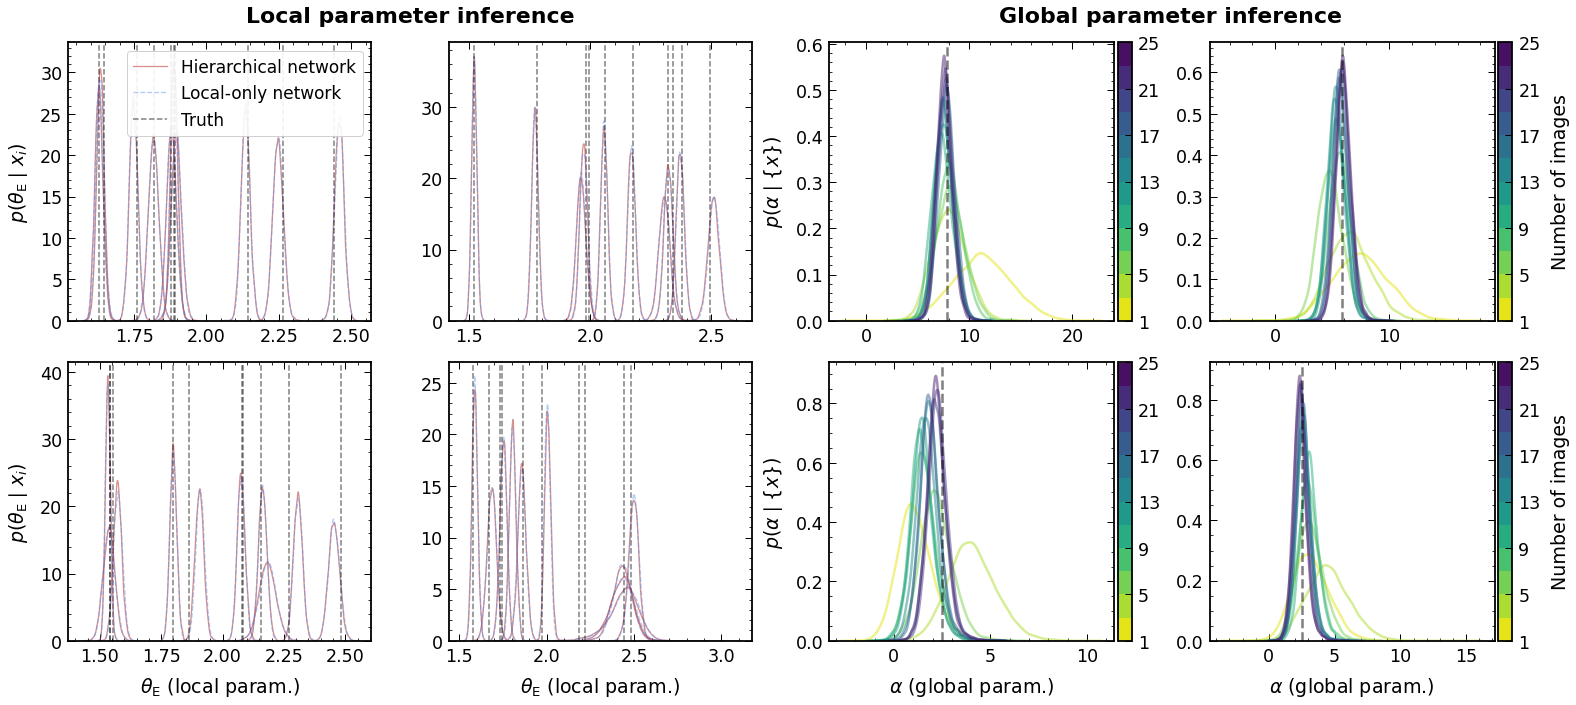

In [87]:
i_param = 2

n_ev_max = 10
n_skip = 2

fig = plt.figure(figsize=(22, 10))
gs = GridSpec(2, 4)

# Create invisible subplots above the columns you want to title
ax1 = fig.add_subplot(gs[0, :2])  # Spanning the first two columns
ax2 = fig.add_subplot(gs[0, 2:4])  # Spanning the last two columns

# Hide everything (plot area, spines, ticks, etc.)
ax1.axis('off')
ax2.axis('off')

# Add the titles
ax1.set_title('Local parameter inference', fontsize=22, fontweight='bold', pad=20)
ax2.set_title('Global parameter inference', fontsize=22, fontweight='bold', pad=20)


for ii, i in enumerate(tqdm([0, 1, 4, 5])):
    
    ii += 2
        
    ax = fig.add_subplot(gs[i])
    plt.cla()
    
    x_enc = model.deep_set.enc.to('cuda')(x_test[ii, :n_ev_max].to('cuda'))
    x_enc, x_enc_cond_local_global = torch.chunk(x_enc, 2, -1)
    x_enc = x_enc.mean(-2)
    x_enc = torch.cat([x_enc.to('cpu'), torch.Tensor([n_ev_max])])
    samples_global = model.deep_set.flow_global.sample(num_samples=32, context=model.deep_set.dec(x_enc.to('cpu')).unsqueeze(0))
    x_enc_cond_local_global = torch.cat([x_enc_cond_local_global.to('cpu'), repeat(samples_global.mean((0,1)), "glob -> n_ev_max glob", n_ev_max=n_ev_max)], -1)    
    samples_global_local = model.deep_set.flow_local.sample(num_samples=5000, context=x_enc_cond_local_global.to('cpu')) * y_local_std + y_local_mean
    
    for iii in range(n_ev_max):
        sns.kdeplot(data=samples_global_local[iii, :, i_param].detach().numpy(), color='firebrick', ax=ax, alpha=1., label="Hierarchical network" if iii==0 else None, lw=1.3)
        
        x_enc = model.deep_set.enc.to('cuda')(x_test[ii, iii].unsqueeze(0).to('cuda'))
        x_enc, x_enc_cond_local_global = torch.chunk(x_enc, 2, -1)
        x_enc = x_enc.mean(-2)
        x_enc = torch.cat([x_enc.to('cpu'), torch.Tensor([1])])
        samples_global = model.deep_set.flow_global.sample(num_samples=32, context=model.deep_set.dec(x_enc.to('cpu')).unsqueeze(0))
        x_enc_cond_local_global = torch.cat([x_enc_cond_local_global.to('cpu'), repeat(samples_global.mean((0,1)), "glob -> n_ev_max glob", n_ev_max=1)], -1)
        
        samples_global_local_local = model.deep_set.flow_local.sample(num_samples=5000, context=x_enc_cond_local_global.to('cpu')) * y_local_std + y_local_mean
        
        sns.kdeplot(data=samples_global_local_local[0, :, i_param].detach().numpy(), color='cornflowerblue', ax=ax, alpha=1., ls='--', label="Local-only network" if iii==0 else None, lw=1.3)
        
        ax.axvline((y_local_test * y_local_std + y_local_mean)[ii,iii].detach().numpy()[i_param], label="Truth" if iii==0 else None, ls='--', color='k', lw=1.5)

    ax.set_ylabel(r"$p(\theta_\mathrm{E}\mid x_i)$" if i in [0, 4] else None)

    for line in ax.get_lines():
        line.set_alpha(0.5)
    
    if i in np.arange(4, 8):
        ax.set_xlabel(r"$\theta_\mathrm{E}$ (local param.)")
    
    if i == 0:
        ax.legend(frameon=True, fancybox=True, framealpha=0.9, loc='upper right')
        
i_param = 1

n_ev_max = 25
n_skip = 2

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(1, n_ev_max + 2, n_skip)

for ii, i in enumerate(tqdm([2, 3, 6, 7])):
    
    ax = fig.add_subplot(gs[i])
    CS3 = ax.contourf(Z, levels, cmap=cmap)
    plt.cla()

    for n_ev in np.arange(1, n_ev_max, n_skip):

        x_enc = model.deep_set.enc.to('cuda')(x_test[ii, :n_ev].to('cuda'))
        x_enc, x_enc_cond_local = torch.chunk(x_enc, 2, -1)

        x_enc = x_enc.mean(-2)
        x_enc = torch.cat([x_enc.to('cpu'), torch.Tensor([n_ev])])
        samples = model.deep_set.flow_global.sample(num_samples=10000, context=model.deep_set.dec(x_enc.to('cpu')).unsqueeze(0)) * y_global_std + y_global_mean

        sns.kdeplot(data=samples[0, :, i_param].detach().numpy(), color=cmap(n_ev / n_ev_max), ax=ax, alpha=0.6)
        ax.set_ylabel(r"$p(\alpha\mid\{x\})$" if i in [2, 6] else None)

    ax.axvline((y_global_test[ii] * y_global_std + y_global_mean).detach().numpy()[i_param], label="Truth", ls='--', color='k')
    for line in ax.get_lines():
        line.set_alpha(0.5)

    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    
    fig.colorbar(CS3, cax=cax, orientation='vertical', label="Number of images" if i in [3,7] else None)
    
    if i in np.arange(4, 8):
        ax.set_xlabel(r"$\alpha$ (global param.)")

    # ax.set_xlim(-2, 2)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.savefig("../paper/figs/lensing_global_local.pdf")